In [1]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
!pip install -q -U tensorflow-text

In [3]:
!pip install natasha

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Import

In [4]:
import re
import time

import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup  # Для удаления HTML тегов

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten, Input, concatenate, Reshape
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import tensorflow_hub as hub
import tensorflow_text as text

from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,

    Doc
)

from matplotlib import pyplot as plt

2023-09-09 17:07:40.082575: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-09 17:07:40.102658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 17:07:40.400577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Settings
Путь до папки с файлом

In [5]:
DIR = '/home/best/Code/HACKATONS/HacksAi_2023/solution/files/'

# Data

Получам данные

In [6]:
df = pd.read_excel(DIR + 'CRA_train_1200.xlsx')

In [7]:
df.head()

,Id,pr_txt,Категория,Уровень рейтинга
0,1,Повышение кредитного рейтинга Акционерного об...,A,A
1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB
2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A
3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA
4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB


In [8]:
df.shape

(1200, 4)

## Data checking

Изучаем данные

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1200 non-null   int64 
 1   pr_txt            1200 non-null   object
 2   Категория         1200 non-null   object
 3   Уровень рейтинга  1200 non-null   object
dtypes: int64(1), object(3)
memory usage: 37.6+ KB


In [10]:
df['Категория'].unique()

array(['A', 'BB', 'AAA', 'BBB', 'AA', 'B', 'C'], dtype=object)

In [11]:
labels_cat = ['A', 'AA', 'AAA', 'B', 'BB', 'BBB', 'C']

In [12]:
df['Уровень рейтинга'].unique()

array(['A', 'BB', 'AAA', 'BBB', 'AA+', 'BB+', 'BB-', 'A-', 'A+', 'B',
       'AA-', 'BBB+', 'BBB-', 'B-', 'AA', 'B+', 'C'], dtype=object)

In [13]:
labels_rat = ['A+', 'A', 'A-', 'AA+', 'AA', 'AA-', 'AAA', 'B+', 'B', 'B-', 'BB+', 'BB', 'BB-', 'BBB+', 'BBB', 'BBB-', 'C']

In [14]:
df['pr_txt'].unique().shape

(1200,)

# Class

Основной класс для работы с NLP

In [15]:
class Nlp:
    def __init__(self):
        # Natasha
        self.segmenter = Segmenter()
        self.morph_vocab = MorphVocab()
        self.emb = NewsEmbedding()
        self.morph_tagger = NewsMorphTagger(self.emb)
        self.syntax_parser = NewsSyntaxParser(self.emb)
        self.ner_tagger = NewsNERTagger(self.emb)
        self.names_extractor = NamesExtractor(self.morph_vocab)
        self.dates_extractor = DatesExtractor(self.morph_vocab)
        self.money_extractor = MoneyExtractor(self.morph_vocab)
        self.addr_extractor = AddrExtractor(self.morph_vocab)


    # Очищаем текст регулярными выражениями
    def clear_text(self, text):
        soup = BeautifulSoup(text)
        text = soup.get_text()
        text = re.sub(r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)', '', text)
        text = re.sub(r'[\n\t]', ' ', text).strip()  # Перенос, табуляция
        text = re.sub(r'[^\w\d\s\.\,]', ' ', text)  # Только слова, цифры, пробелы, точки и запятые
        text = re.sub(r'\s+', ' ', text)  # Удаляем двойные пробелы
        return text


    # Извлекаем фичи
    def get_features(self, df):
        start_time = time.time()
        features_list = []
        for i in range(df.shape[0]):
            ner_list = self.get_ner_features(df.iloc[i])
            words = df.iloc[i].split()
            count = len(words)  # Количество слов в строке
            if count > 0:
                average = sum(len(word) for word in words) / count
                uniq = round(100*len(set(words))/count)  # % уникальных слов в строке
                features_list.append(ner_list + [count, average, uniq])
            if (i+1) % 10 == 0:
                delta_time = round(time.time() - start_time)
                print(f'Обработано {i+1} из {df.shape[0]}, {delta_time}c')
        return np.array(features_list)


    # В категорийные признаки
    def to_categorical(self, df, labels):
        le = LabelEncoder()
        le.fit(labels)
        label = le.transform(df)
        return to_categorical(label, num_classes=len(labels), dtype='int')


    # Возвращает список с количеством найденных именованных сущностей [names, dates, LOC, MONEY]
    def get_ner_features(self, text):
        names = len(list(nlp.names_extractor(text)))
        money = len(list(nlp.money_extractor(text)))
        addr = len(list(nlp.addr_extractor(text)))
        # dates = len(list(nlp.dates_extractor(text)))  # Выдаёт ошибку на текст с 'маю'
        # return [names, dates, money, addr]
        return [names, money, addr]


    # Извлекает именнованные сущности - имена, названия
    def names_extractor(self, text):
        return self.names_extractor(text)


    # Извлекает именнованные сущности - даты
    def dates_extractor(self, text):
        return self.dates_extractor(text)


    # Извлекает именнованные сущности - деньги
    def money_extractor(self, text):
        return self.money_extractor(text)


    # Извлекает именнованные сущности - локацию, адреса
    def addr_extractor(self, text):
        return self.addr_extractor(text)

In [16]:
nlp = Nlp()

# Cleaning up text
Очищаем текст HTML, гиперссылок, прочих ненужных символов и двойных пробелов

In [17]:
sample_text = ' Присвоенный  https://raexpert.ru/ratings/methods/current ")     рейтинг и прогноз <rating> по нему отражают всю существенную информацию в отношении  объекта рейтинга'

In [18]:
cleared_text = nlp.clear_text(sample_text)
print('ДО:', sample_text)
print()
print('ПОСЛЕ:', cleared_text)

ДО:  Присвоенный  https://raexpert.ru/ratings/methods/current ")     рейтинг и прогноз <rating> по нему отражают всю существенную информацию в отношении  объекта рейтинга

ПОСЛЕ: Присвоенный рейтинг и прогноз по нему отражают всю существенную информацию в отношении объекта рейтинга


In [19]:
cleared_text_list = []
for i in range(df.shape[0]):
    text = nlp.clear_text(df['pr_txt'].iloc[i])
    cleared_text_list.append(text)

print(len(cleared_text_list))

1200


# To categorical

Переводим каегории и рейтинги в OHE

In [20]:
cat_categorical = nlp.to_categorical(df['Категория'], labels_cat)
rating_categorical = nlp.to_categorical(df['Уровень рейтинга'], labels_rat)
print(cat_categorical.shape, rating_categorical.shape)

(1200, 7) (1200, 17)


# To dataFrame

In [21]:
df_text = pd.DataFrame(cleared_text_list, columns=['text'])
df_cat = pd.DataFrame(cat_categorical)
df_rat = pd.DataFrame(rating_categorical)
print(df_text.shape, df_cat.shape, df_rat.shape)

(1200, 1) (1200, 7) (1200, 17)


## Feature Extraction
Извлекаем дополнительные признаки, такие как:
- NER - имена, названия
- NER - даты
- NER - деньги  # Выкидывает ошибку на обработке некоторых текстов
- NER - локации, адреса
- длинна текста
- средняя длинна слова
- уникальность текста

ВНИМАНИЕ!
Извлечение именованных сущностей - долгий процесс!!!

In [22]:
x_features = nlp.get_features(df_text['text'])
x_features.shape

Обработано 10 из 1200, 19c
Обработано 20 из 1200, 40c
Обработано 30 из 1200, 64c
Обработано 40 из 1200, 86c
Обработано 50 из 1200, 111c
Обработано 60 из 1200, 136c
Обработано 70 из 1200, 162c
Обработано 80 из 1200, 185c
Обработано 90 из 1200, 210c
Обработано 100 из 1200, 237c
Обработано 110 из 1200, 264c
Обработано 120 из 1200, 294c
Обработано 130 из 1200, 321c
Обработано 140 из 1200, 348c
Обработано 150 из 1200, 377c
Обработано 160 из 1200, 401c
Обработано 170 из 1200, 424c
Обработано 180 из 1200, 452c
Обработано 190 из 1200, 479c
Обработано 200 из 1200, 508c
Обработано 210 из 1200, 533c
Обработано 220 из 1200, 563c
Обработано 230 из 1200, 588c
Обработано 240 из 1200, 613c
Обработано 250 из 1200, 639c
Обработано 260 из 1200, 668c
Обработано 270 из 1200, 693c
Обработано 280 из 1200, 719c
Обработано 290 из 1200, 747c
Обработано 300 из 1200, 774c
Обработано 310 из 1200, 803c
Обработано 320 из 1200, 830c
Обработано 330 из 1200, 854c
Обработано 340 из 1200, 882c
Обработано 350 из 1200, 912

(1200, 6)

In [23]:
x_features

array([[3.94000000e+02, 4.00000000e+00, 1.00000000e+00, 1.07000000e+03,
        6.83644860e+00, 5.40000000e+01],
       [2.48000000e+02, 4.00000000e+00, 4.00000000e+00, 1.01300000e+03,
        7.08193485e+00, 6.00000000e+01],
       [4.39000000e+02, 0.00000000e+00, 4.00000000e+00, 1.52400000e+03,
        6.79199475e+00, 5.70000000e+01],
       ...,
       [3.71000000e+02, 7.00000000e+00, 2.00000000e+00, 1.19300000e+03,
        6.51047779e+00, 5.10000000e+01],
       [3.42000000e+02, 1.00000000e+01, 3.60000000e+01, 1.29900000e+03,
        6.95150115e+00, 5.70000000e+01],
       [4.10000000e+02, 9.00000000e+00, 7.00000000e+00, 1.56300000e+03,
        6.63659629e+00, 5.50000000e+01]])

In [24]:
x_features_np = np.array(x_features)

In [25]:
np.save(DIR + 'x_features_2.npy', x_features_np)

In [26]:
df_features = pd.DataFrame(x_features, columns=['name', 'date', 'location', 'count', 'average', 'uniq'])
df_features.to_csv(DIR + 'df_features_2.csv')
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      1200 non-null   float64
 1   date      1200 non-null   float64
 2   location  1200 non-null   float64
 3   count     1200 non-null   float64
 4   average   1200 non-null   float64
 5   uniq      1200 non-null   float64
dtypes: float64(6)
memory usage: 56.4 KB


In [27]:
# x_features_np = numpy.load(DIR + 'x_features_2.npy')

In [28]:
# df_features = pd.read_csv(DIR + 'df_features_2.csv')

# Data analysis

### Histogramm

Text(0, 0.5, 'Количество текстов')

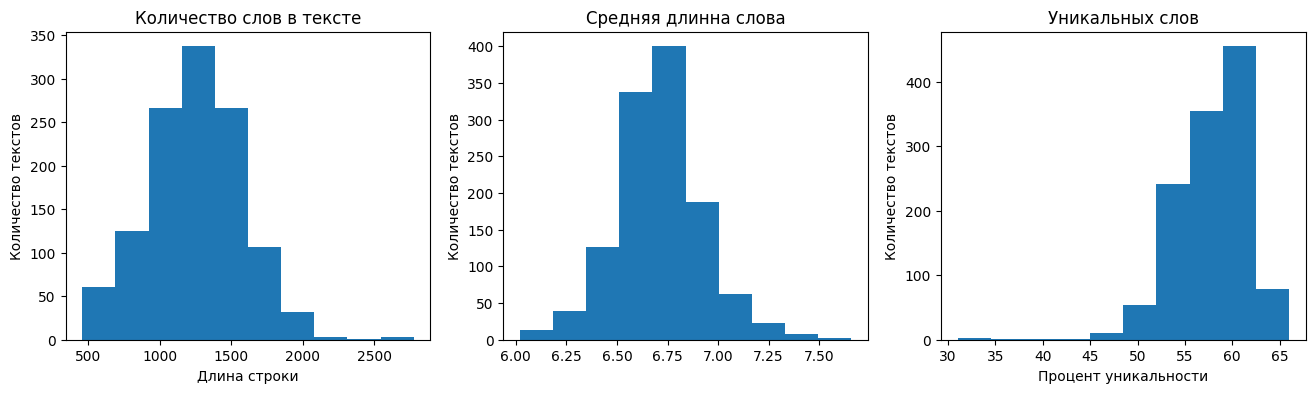

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

n_bins = 10
axs[0].hist(x_features_np[:,3], bins=n_bins)
axs[0].set_title('Количество слов в тексте')
axs[0].set_xlabel("Длина строки")
axs[0].set_ylabel("Количество текстов")
axs[1].hist(x_features_np[:,4], bins=n_bins)
axs[1].set_title('Средняя длинна слова')
axs[1].set_ylabel("Количество текстов")
axs[2].hist(x_features_np[:,5], bins=n_bins)
axs[2].set_title('Уникальных слов')
axs[2].set_xlabel("Процент уникальности")
axs[2].set_ylabel("Количество текстов")

### Scatter

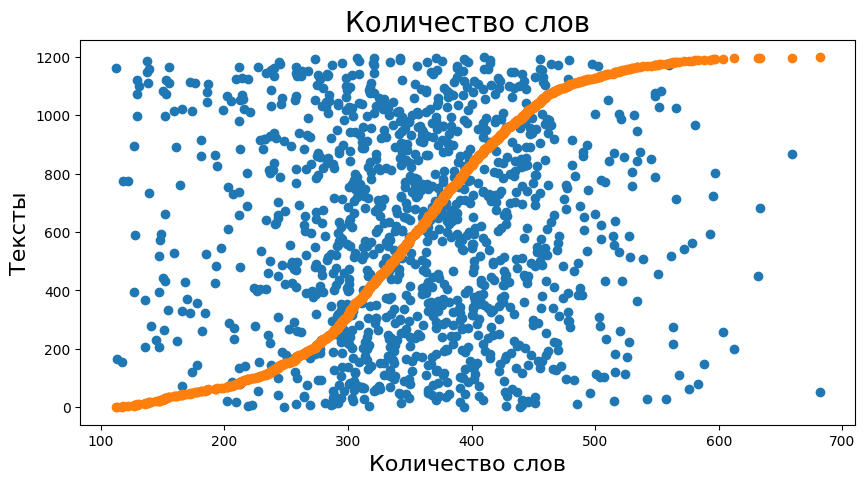

In [30]:
x_np = np.arange(0, df_text['text'].shape[0])

plt.figure(figsize=(10, 5))
plt.title(label = 'Количество слов', fontsize=20)
plt.xlabel('Количество слов', fontsize=16)
plt.ylabel('Тексты', fontsize=16)
plt.scatter(x_features_np[:,0], x_np)
plt.scatter(np.sort(x_features_np[:,0]), x_np)
plt.show()

### Fractions

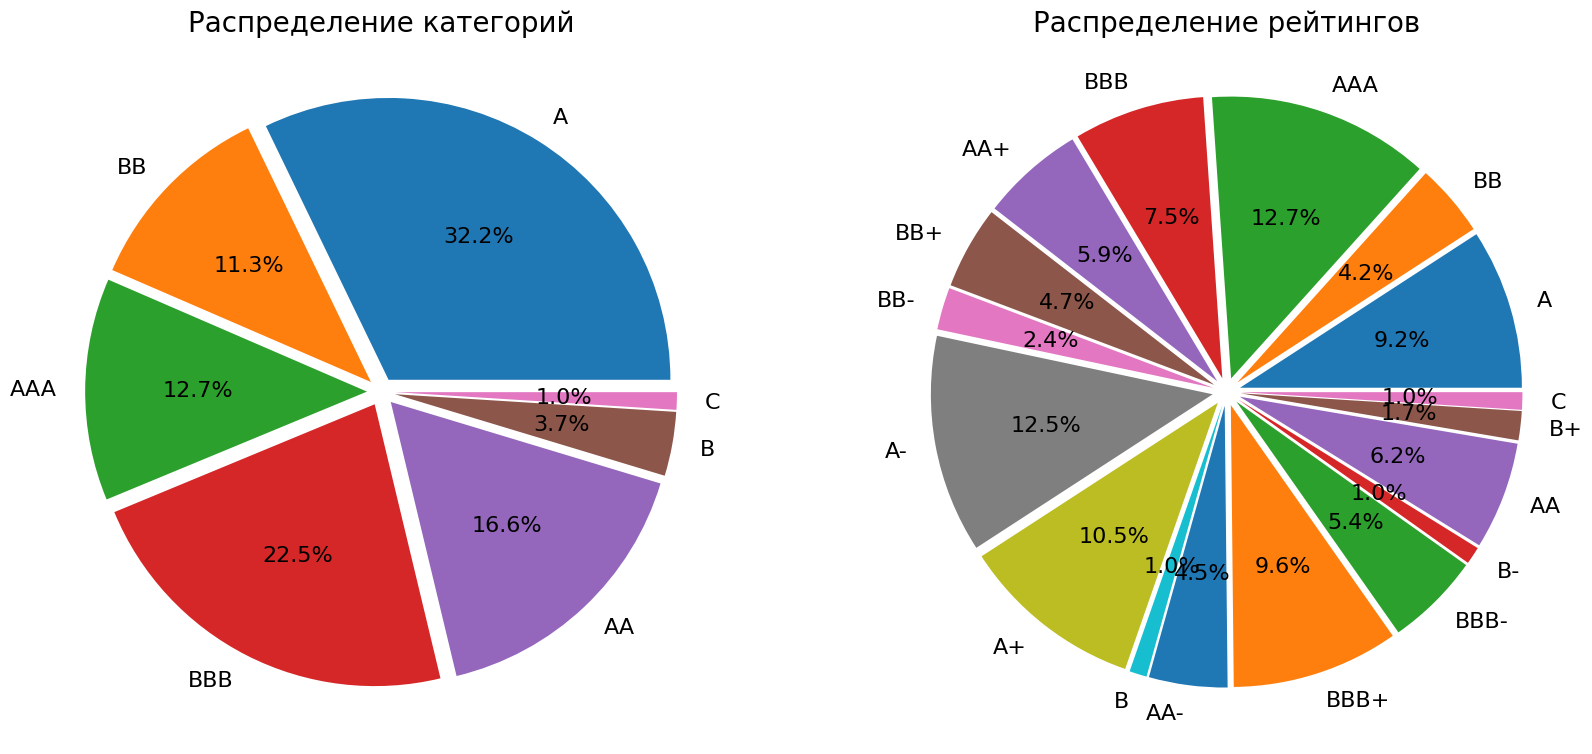

In [31]:
# === Категории ===
cat_list = ['A', 'BB', 'AAA', 'BBB', 'AA', 'B', 'C']
cat_frac_list = []
for cat in cat_list:
  frac = round(100*df[df['Категория'] == cat].shape[0]/df.shape[0], 2)
  cat_frac_list.append(frac)

# === Рейтинги ===
rat_list = ['A', 'BB', 'AAA', 'BBB', 'AA+', 'BB+', 'BB-', 'A-', 'A+', 'B', 'AA-', 'BBB+', 'BBB-', 'B-', 'AA', 'B+', 'C']
rat_frac_list = []
for rat in rat_list:
  frac = round(100*df[df['Уровень рейтинга'] == rat].shape[0]/df.shape[0], 2)
  rat_frac_list.append(frac)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].pie(cat_frac_list, labels=cat_list, autopct='%1.1f%%', explode=(0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05), textprops = {"fontsize":16})
axs[0].set_title(label='Распределение категорий', fontsize=20)
axs[1].pie(rat_frac_list, labels=rat_list, autopct='%1.1f%%', explode=(0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05), textprops = {"fontsize":16})
axs[1].set_title(label='Распределение рейтингов', fontsize=20)
plt.show()


# train_test_split

In [32]:
x_cat_train, x_cat_val, y_cat_train, y_cat_val = train_test_split(df_text, df_cat, train_size=0.8, random_state=12)
x_rat_train, x_rat_val, y_rat_train, y_rat_val = train_test_split(df_text, df_rat, train_size=0.8, random_state=12)
x_feat_train, x_feat_val = train_test_split(x_features, train_size=0.8, random_state=12)

In [33]:
print(x_cat_train.shape, x_cat_val.shape)
print(x_rat_train.shape, x_rat_val.shape)
print(x_feat_train.shape, x_feat_val.shape)

(960, 1) (240, 1)
(960, 1) (240, 1)
(960, 6) (240, 6)


In [34]:
print(y_cat_train.shape, y_cat_val.shape)
print(y_rat_train.shape, y_rat_val.shape)

(960, 7) (240, 7)
(960, 17) (240, 17)


# Loading the BERT Model
We will load two models, one for pre-processing and one for coding. Model links are below.

In [35]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4", trainable=True)

2023-09-09 18:03:10.363118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-09 18:03:10.633718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-09 18:03:10.634043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Initializing BERT Layers
In the code below, create an input layer using the tf.keras.layers.Input method. Will use **preprocessed_text** as input for this layer.

The **bert_encoder** function then converts the preprocessed text into embadding vectors. This will be the output of this layer. The **outputs** will then be passed to the layers of the neural network.

In [47]:
text_input = Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# === model_cat ===
Модель для работы с категориями
Представляет собой Fine Tuning BERT (SOTA) - предварительно обученная модель, которая дообучается на наших данных.
Дополнительно для улучшения скора - создаём дополнительный вход и подаём туда фичи.
Итого, модель с 2 входами:
- текст
- 6 признаков


## Model with multiple inputs
Модель с двумя входами

In [48]:
text_input = Input(shape=(), dtype=tf.string, name='text_input')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

features_input = Input(shape=(6), name='features_input')
x_1 = outputs['pooled_output']
x_2 = Dense(6, activation='relu')(features_input)
x = concatenate([x_1, x_2])
x = Dropout(0.25)(x)
x_output = Dense(7, activation='softmax')(x)

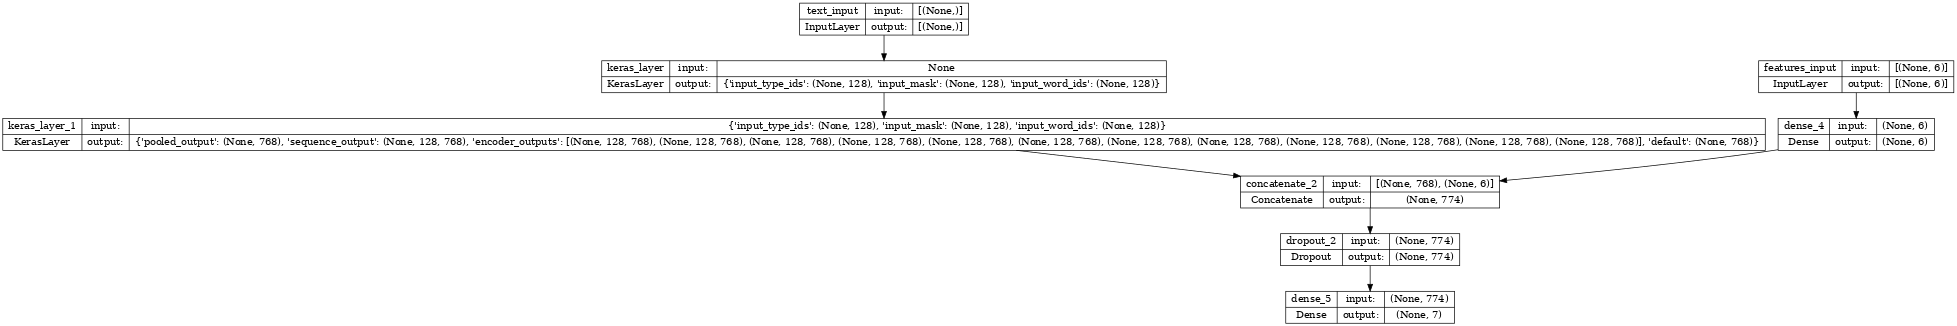

In [49]:
model_cat = Model(inputs=[text_input, features_input], outputs = [x_output])
plot_model(model_cat, show_shapes=True, expand_nested=True, show_layer_names=True, dpi=50)

In [50]:
print(model_cat.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text_input[0][0]']          
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

## Model complite
Особенность - очень маленький шаг обучения. Для ускорения обучения до 5 - 7 эпох, можно поднять learning_rate до 0.00005, но не более. Далее - существенное снижение точности.

In [51]:
model_cat.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=(0.00001)), metrics=['accuracy'])

checkpointer = ModelCheckpoint(
  filepath = DIR + 'model_cat_2_w.h5',
  monitor = 'val_accuracy',
  mode = 'max',
  verbose = 1,
  save_best_only = True
)

In [52]:
history = model_cat.fit(
  [x_cat_train, x_feat_train],
  y_cat_train,
  epochs = 70,
  batch_size = 16,
  validation_data = ([x_cat_val, x_feat_val], y_cat_val),
  callbacks = [checkpointer],
  verbose = 1
)

Epoch 1/70
60/60 [==============================] - ETA: 0s - loss: 62.0345 - accuracy: 0.1760
Epoch 1: val_accuracy improved from -inf to 0.27500, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_cat_2_w.h5


/home/best/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 23s 199ms/step - loss: 62.0345 - accuracy: 0.1760 - val_loss: 42.7852 - val_accuracy: 0.2750
Epoch 2/70
60/60 [==============================] - ETA: 0s - loss: 56.9967 - accuracy: 0.1958
Epoch 2: val_accuracy improved from 0.27500 to 0.27917, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_cat_2_w.h5
60/60 [==============================] - 10s 168ms/step - loss: 56.9967 - accuracy: 0.1958 - val_loss: 38.5776 - val_accuracy: 0.2792
Epoch 3/70
60/60 [==============================] - ETA: 0s - loss: 51.2195 - accuracy: 0.2292
Epoch 3: val_accuracy improved from 0.27917 to 0.30833, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_cat_2_w.h5
60/60 [==============================] - 10s 166ms/step - loss: 51.2195 - accuracy: 0.2292 - val_loss: 35.7072 - val_accuracy: 0.3083
Epoch 4/70
60/60 [==============================] - ETA: 0s - loss: 49.5128 - accuracy: 0.2313
Epoch 4: val_accuracy impro

60/60 [==============================] - 9s 148ms/step - loss: 15.5036 - accuracy: 0.4542 - val_loss: 11.0028 - val_accuracy: 0.5167
Epoch 27/70
60/60 [==============================] - ETA: 0s - loss: 15.1054 - accuracy: 0.4521
Epoch 27: val_accuracy did not improve from 0.51667
60/60 [==============================] - 7s 119ms/step - loss: 15.1054 - accuracy: 0.4521 - val_loss: 9.7710 - val_accuracy: 0.5125
Epoch 28/70
60/60 [==============================] - ETA: 0s - loss: 14.3632 - accuracy: 0.4708
Epoch 28: val_accuracy improved from 0.51667 to 0.52500, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_cat_2_w.h5
60/60 [==============================] - 9s 150ms/step - loss: 14.3632 - accuracy: 0.4708 - val_loss: 8.3199 - val_accuracy: 0.5250
Epoch 29/70
60/60 [==============================] - ETA: 0s - loss: 13.1274 - accuracy: 0.4729
Epoch 29: val_accuracy improved from 0.52500 to 0.53750, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solutio

60/60 [==============================] - 9s 151ms/step - loss: 2.7527 - accuracy: 0.7885 - val_loss: 6.2982 - val_accuracy: 0.7375
Epoch 52/70
60/60 [==============================] - ETA: 0s - loss: 2.7538 - accuracy: 0.8094
Epoch 52: val_accuracy improved from 0.73750 to 0.74583, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_cat_2_w.h5
60/60 [==============================] - 9s 148ms/step - loss: 2.7538 - accuracy: 0.8094 - val_loss: 5.9330 - val_accuracy: 0.7458
Epoch 53/70
60/60 [==============================] - ETA: 0s - loss: 2.6101 - accuracy: 0.8146
Epoch 53: val_accuracy did not improve from 0.74583
60/60 [==============================] - 7s 119ms/step - loss: 2.6101 - accuracy: 0.8146 - val_loss: 6.5471 - val_accuracy: 0.7333
Epoch 54/70
60/60 [==============================] - ETA: 0s - loss: 2.4936 - accuracy: 0.8313
Epoch 54: val_accuracy did not improve from 0.74583
60/60 [==============================] - 7s 120ms/step - loss: 2.4936 - ac

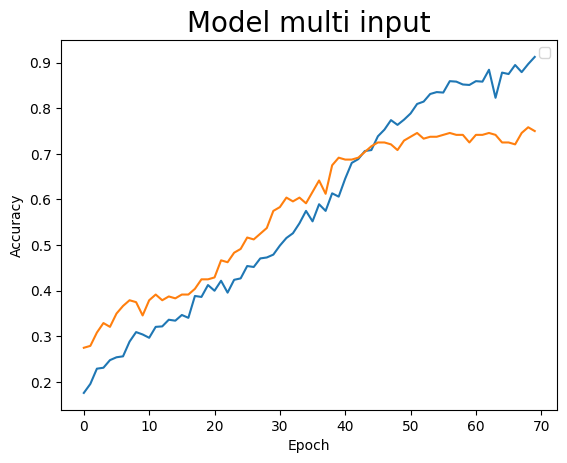

In [53]:
# Оображаем график точности обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(label='Model multi input', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate the model
Загружаем лучшие веса модели и оцениваем модель

In [54]:
model_cat.load_weights(DIR + 'model_cat_2_w.h5')

In [55]:
loss, accuracy = model_cat.evaluate([x_cat_train, x_feat_train], y_cat_train)
print(f'Train, accuracy: {accuracy}, loss: {loss}')
print()

val_loss, val_accuracy = model_cat.evaluate([x_cat_val, x_feat_val], y_cat_val)
print(f'Val, accuracy: {val_accuracy}, loss: {val_loss}')

30/30 [==============================] - 5s 147ms/step - loss: 0.3803 - accuracy: 0.9750
Train, accuracy: 0.9750000238418579, loss: 0.38029536604881287

8/8 [==============================] - 1s 138ms/step - loss: 6.9644 - accuracy: 0.7583
Val, accuracy: 0.7583333253860474, loss: 6.964447498321533


In [56]:
y_pred_v = model_cat.predict([x_cat_val, x_feat_val])
y_pred_am = np.argmax(y_pred_v, axis=1)
y_pred = to_categorical(y_pred_am,  num_classes=7, dtype='int')
print(y_cat_val.shape, y_pred.shape)

8/8 [==============================] - 1s 119ms/step
(240, 7) (240, 7)


In [57]:
y_pred

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [58]:
y_cat_val

,0,1,2,3,4,5,6
1074,1,0,0,0,0,0,0
289,0,0,0,0,1,0,0
883,0,0,0,1,0,0,0
1045,1,0,0,0,0,0,0
1057,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
915,0,0,0,0,0,1,0
217,1,0,0,0,0,0,0
168,0,0,0,0,0,1,0
1104,1,0,0,0,0,0,0


In [59]:
f1 = sklearn.metrics.f1_score(y_cat_val, y_pred, average='macro')
print(f1)

0.6578855244176901


# Save model

In [61]:
model_cat.save(DIR + 'model_cat_2.keras')

# === model_rating ===
Модель для работы с рейтингом
Представляет собой Fine Tuning BERT (SOTA) - предварительно обученная модель, которая дообучается на наших данных.
Дополнительно для улучшения скора - создаём дополнительный вход и подаём туда фичи.
Итого, модель с 2 входами:
- текст
- 6 признаков

## Model with multiple inputs
Модель с двумя входами

In [62]:
text_input = Input(shape=(), dtype=tf.string, name='text_input')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

features_input = Input(shape=(6), name='features_input')
x_1 = outputs['pooled_output']
x_2 = Dense(6, activation='relu')(features_input)
x = concatenate([x_1, x_2])
x = Dropout(0.25)(x)
x_output = Dense(17, activation='softmax')(x)

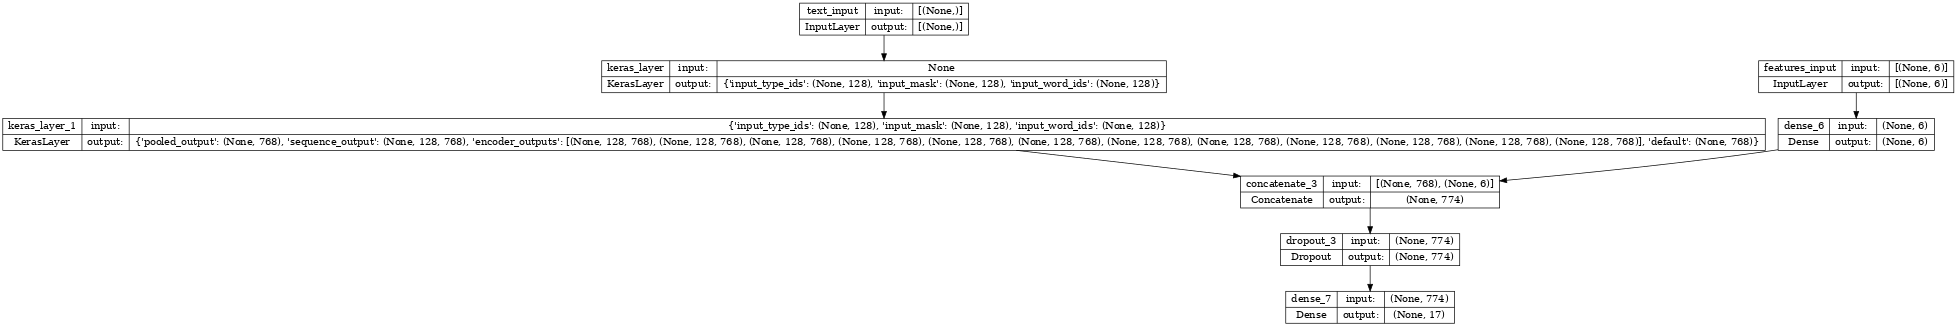

In [63]:
model_rat = Model(inputs=[text_input, features_input], outputs = [x_output])
plot_model(model_rat, show_shapes=True, expand_nested=True, show_layer_names=True, dpi=50)

In [64]:
print(model_rat.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text_input[0][0]']          
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

## Model complite
Особенность - очень маленький шаг обучения. Для ускорения обучения до 5 - 7 эпох, можно поднять learning_rate до 0.00005, но не более. Далее - существенное снижение точности.

In [65]:
model_rat.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=(0.00001)), metrics=['accuracy'])

checkpointer = ModelCheckpoint(
  filepath = DIR + 'model_rat_2_w.h5',
  monitor = 'val_accuracy',
  mode = 'max',
  verbose = 1,
  save_best_only = True
)

In [66]:
history = model_rat.fit(
  [x_rat_train, x_feat_train],
  y_rat_train,
  epochs = 100,
  batch_size = 16,
  validation_data = ([x_rat_val, x_feat_val], y_rat_val),
  callbacks = [checkpointer],
  verbose = 1
)

Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 36.1081 - accuracy: 0.1042
Epoch 1: val_accuracy improved from -inf to 0.15000, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_rat_2_w.h5


/home/best/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 22s 175ms/step - loss: 36.1081 - accuracy: 0.1042 - val_loss: 26.2236 - val_accuracy: 0.1500
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 31.2263 - accuracy: 0.1833
Epoch 2: val_accuracy improved from 0.15000 to 0.15833, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_rat_2_w.h5
60/60 [==============================] - 10s 172ms/step - loss: 31.2263 - accuracy: 0.1833 - val_loss: 22.8759 - val_accuracy: 0.1583
Epoch 3/100
60/60 [==============================] - ETA: 0s - loss: 29.7097 - accuracy: 0.1708
Epoch 3: val_accuracy did not improve from 0.15833
60/60 [==============================] - 8s 135ms/step - loss: 29.7097 - accuracy: 0.1708 - val_loss: 19.6356 - val_accuracy: 0.1500
Epoch 4/100
60/60 [==============================] - ETA: 0s - loss: 26.9989 - accuracy: 0.1844
Epoch 4: val_accuracy improved from 0.15833 to 0.17500, saving model to /home/best/Code/HACKATONS/HacksAi_2023/soluti

60/60 [==============================] - ETA: 0s - loss: 8.9235 - accuracy: 0.4969
Epoch 25: val_accuracy did not improve from 0.45000
60/60 [==============================] - 7s 119ms/step - loss: 8.9235 - accuracy: 0.4969 - val_loss: 9.1538 - val_accuracy: 0.4458
Epoch 26/100
60/60 [==============================] - ETA: 0s - loss: 8.8486 - accuracy: 0.5167
Epoch 26: val_accuracy did not improve from 0.45000
60/60 [==============================] - 7s 118ms/step - loss: 8.8486 - accuracy: 0.5167 - val_loss: 8.2796 - val_accuracy: 0.4458
Epoch 27/100
60/60 [==============================] - ETA: 0s - loss: 8.6979 - accuracy: 0.5219
Epoch 27: val_accuracy improved from 0.45000 to 0.46667, saving model to /home/best/Code/HACKATONS/HacksAi_2023/solution/files/model_rat_2_w.h5
60/60 [==============================] - 9s 149ms/step - loss: 8.6979 - accuracy: 0.5219 - val_loss: 7.4696 - val_accuracy: 0.4667
Epoch 28/100
60/60 [==============================] - ETA: 0s - loss: 7.5081 - accur

Epoch 52/100
60/60 [==============================] - ETA: 0s - loss: 2.7677 - accuracy: 0.8031
Epoch 52: val_accuracy did not improve from 0.57917
60/60 [==============================] - 7s 120ms/step - loss: 2.7677 - accuracy: 0.8031 - val_loss: 10.1062 - val_accuracy: 0.5625
Epoch 53/100
60/60 [==============================] - ETA: 0s - loss: 2.5507 - accuracy: 0.8031
Epoch 53: val_accuracy did not improve from 0.57917
60/60 [==============================] - 7s 119ms/step - loss: 2.5507 - accuracy: 0.8031 - val_loss: 8.6162 - val_accuracy: 0.5583
Epoch 54/100
60/60 [==============================] - ETA: 0s - loss: 2.4100 - accuracy: 0.8115
Epoch 54: val_accuracy did not improve from 0.57917
60/60 [==============================] - 7s 119ms/step - loss: 2.4100 - accuracy: 0.8115 - val_loss: 9.5433 - val_accuracy: 0.5708
Epoch 55/100
60/60 [==============================] - ETA: 0s - loss: 2.5164 - accuracy: 0.8219
Epoch 55: val_accuracy improved from 0.57917 to 0.58333, saving mo

Epoch 81/100
60/60 [==============================] - ETA: 0s - loss: 1.1528 - accuracy: 0.8990
Epoch 81: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 118ms/step - loss: 1.1528 - accuracy: 0.8990 - val_loss: 10.6731 - val_accuracy: 0.5750
Epoch 82/100
60/60 [==============================] - ETA: 0s - loss: 0.8441 - accuracy: 0.9000
Epoch 82: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 118ms/step - loss: 0.8441 - accuracy: 0.9000 - val_loss: 10.9859 - val_accuracy: 0.5667
Epoch 83/100
60/60 [==============================] - ETA: 0s - loss: 0.8131 - accuracy: 0.9104
Epoch 83: val_accuracy did not improve from 0.61250
60/60 [==============================] - 7s 119ms/step - loss: 0.8131 - accuracy: 0.9104 - val_loss: 9.7399 - val_accuracy: 0.5708
Epoch 84/100
60/60 [==============================] - ETA: 0s - loss: 0.7529 - accuracy: 0.9344
Epoch 84: val_accuracy did not improve from 0.61250
60/60 [======

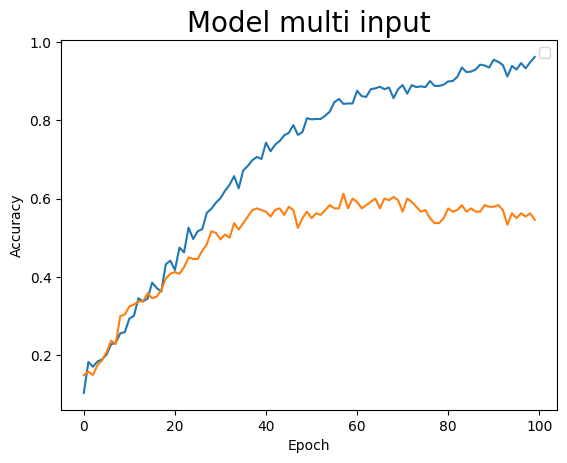

In [67]:
# Оображаем график точности обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(label='Model multi input', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate the model
Загружаем лучшие веса модели и оцениваем модель

In [68]:
model_rat.load_weights(DIR + 'model_rat_2.h5')

In [69]:
loss, accuracy = model_rat.evaluate([x_rat_train, x_feat_train], y_rat_train)
print(f'Train, accuracy: {accuracy}, loss: {loss}')
print()

val_loss, val_accuracy = model_rat.evaluate([x_rat_val, x_feat_val], y_rat_val)
print(f'Val, accuracy: {val_accuracy}, loss: {val_loss}')

30/30 [==============================] - 5s 150ms/step - loss: 0.3510 - accuracy: 0.9771
Train, accuracy: 0.9770833253860474, loss: 0.3509778380393982

8/8 [==============================] - 1s 134ms/step - loss: 10.2057 - accuracy: 0.6125
Val, accuracy: 0.612500011920929, loss: 10.205674171447754


In [70]:
y_pred_v = model_rat.predict([x_rat_val, x_feat_val])
y_pred_am = np.argmax(y_pred_v, axis=1)
y_pred = to_categorical(y_pred_am,  num_classes=17, dtype='int')
print(y_rat_val.shape, y_pred.shape)

8/8 [==============================] - 1s 122ms/step
(240, 17) (240, 17)


In [71]:
y_pred

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [72]:
y_rat_val

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1074,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
289,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
883,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1045,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1057,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
217,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
168,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1104,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
f1 = sklearn.metrics.f1_score(y_rat_val, y_pred, average='macro')
print(f1)

0.47777140799212103


In [74]:
model_rat.save(DIR + 'model_rat_2.keras')

# Summary
Подводим итоги - извлечение именованных сущностей и извлечение дополнительных признаков долгий процесс, но этот подход увеличивает точность на 2 - 3%